In [1]:
from __future__ import division
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

mpl.style.use('http://tiny.cc/leheny-style-sans-serif/raw')

from snase_analysis import *
import snase_analysis
reload(snase_analysis)
Curve = snase_analysis.Curve

/home/dallan/anaconda/lib/python2.7/site-packages/sqlalchemy/sql/type_api.py:322: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  d[coltype] = rp = d['impl'].result_processor(dialect, coltype)


In [2]:
curve = Curve('AT42', 8)
curve.spec

,id,trial,video,start,stop,flip,timestamp
288,289,AT42,8,590,1018,1,2014-04-08 23:53:28.165888
289,290,AT42,8,2272,3500,0,2014-04-08 23:54:12.706178
290,291,AT42,8,3500,5344,1,2014-04-08 23:54:36.454021
291,292,AT42,8,5345,6725,0,2014-04-08 23:55:11.079202
292,293,AT42,8,6725,8176,1,2014-04-08 23:55:30.754993
293,294,AT42,8,8176,9623,0,2014-04-08 23:55:56.318479
294,295,AT42,8,9623,11026,1,2014-04-08 23:56:15.466488
295,296,AT42,8,11026,12597,0,2014-04-08 23:56:38.694747
296,297,AT42,8,12597,14446,1,2014-04-08 23:56:55.377506
297,298,AT42,8,14446,15917,0,2014-04-08 23:57:16.213318


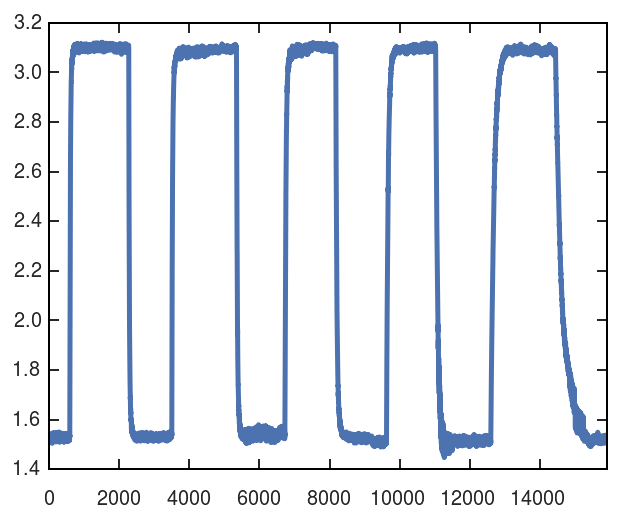

In [3]:
curve.data.plot()

### Viscous

Written in Paper: $ \theta(t) = 2 \tan^{-1} \left[ \exp \left( -\frac{\mu B}{\zeta_r} (t-t_0) \right) \right]$

Programmed Below: $\theta(t) = \left\{
                    \begin{array}{lr}
                    2 \tan^{-1} \left[ \exp \left( -K(t-t_0)\right) \right] & : t > t_0\\
                    \frac{\pi}{2} & : t < t_0
                    \end{array}
                    \right.$

In [4]:
from lmfit import Model

def viscous(t, K, t0):
    theta = 2*np.arctan(np.exp(-K*(t-t0)))
    theta = np.where(t < t0, np.pi/2, theta)
    return theta

viscous_model = Model(viscous, ['t'])

1.961827405356888

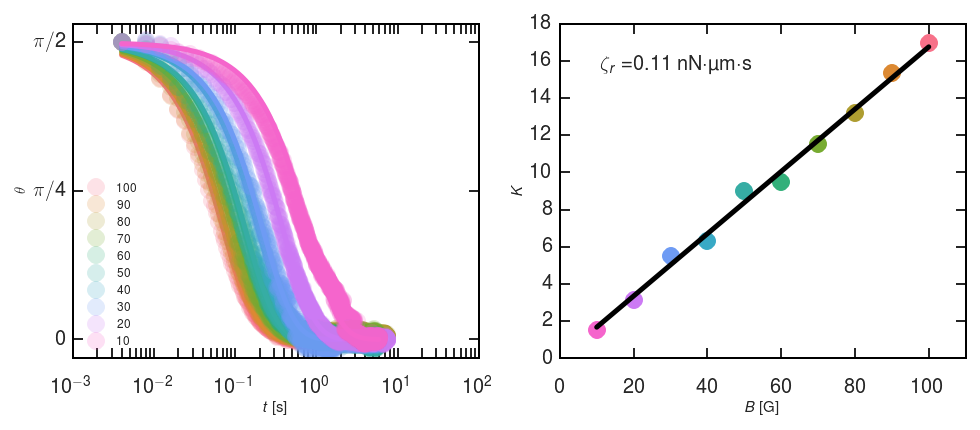

In [5]:
with sns.color_palette("husl", len(curve.rotations)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
collected_K = []

fields = curve.metadata['fields']

for rotation, field in zip(curve.rotations, fields):
    rotation = align_head(rotation)
    t = np.arange(1, 1 + len(rotation)) / curve.fps
    fit_result = viscous_model.fit(rotation, K=1, t0=Parameter(value=0, vary=False), t=t)
    
    # Evaluate the model on a denser grid for smooth plotting.
    dense_t = np.logspace(np.log10(t[0]), np.log10(t[-1]), num=200)
    line, = ax1.plot(t, rotation, 'o', label=field, alpha=0.2)
    ax1.plot(dense_t, fit_result.eval(t=dense_t), color=line.get_color())
    
    # Plot K
    K = fit_result.values['K']
    ax2.plot(field, K, 'o', color=line.get_color())
    
    collected_K.append(K)
    
# Select colinear points.
good_slice = slice(None)
    
# Compute zeta.
x = np.asarray(fields)[good_slice]
y = np.asarray(collected_K)[good_slice]
slope, = sm.OLS(y, x).fit().params
zeta = curve.mu/slope * 1e11  # nN um s (micro-Newton micron seconds)
eta = zeta / (1.48 * curve.wire_length**2) * 1e3 # uPa m s

ax2.plot(np.asarray(fields)[good_slice], x * slope, 'k-')
ax2.text(0.1, 0.85, r'$\zeta_r=${zeta:.2} nN$\cdot$\textmu m$\cdot$s'.format(zeta=zeta), transform=ax2.transAxes)
    
wire_rotation_axes(ax1)
ax1.set(xscale='log', xlabel=r'$t$ [s]')
ax1.set(ylim=(-0.1, np.pi/2 + 0.1), xlim=(1e-3, 100))
ax1.legend(loc='lower left')

ax2.set(xlim=(min(fields) - np.abs(np.diff(fields)).min(), max(fields) + np.abs(np.diff(fields)).min()))
ax2.set(xlabel=r'$B$ [G]', ylabel=r'$K$')

eta

In [6]:
with YAML('viscosity.yml') as results:
    try:
        trial = results[curve.trial]
    except KeyError:
        results[curve.trial] = {}
    results[curve.trial][curve.video] = {'zeta': float(zeta), 'eta': float(eta)}

In [7]:
cat viscosity.yml

AT39:
  1:
    eta: 1.3539459778580478
    zeta: 0.12792534899916225
  2:
    eta: 4.8414076553758365
    zeta: 1.2484789674115748
  3:
    eta: 2.3158869147983605
    zeta: 0.6756367744148923
  4:
    eta: 6.5209368090837145
    zeta: 0.6145786792782184
  5:
    eta: 6.840713435857565
    zeta: 0.8237135085115839
AT40:
  2:
    eta: 0.23221636615608718
    zeta: 0.02271619725962978
  3:
    eta: 0.2453098201286839
    zeta: 0.023997043602094148
  4:
    eta: 0.27830991926165877
    zeta: 0.027225225895619994
  5:
    eta: 0.29960565249916044
    zeta: 0.02930844718195421
  6:
    eta: 0.347320791703942
    zeta: 0.03397610490302091
  7:
    eta: 0.44350979424275794
    zeta: 0.04338564132824455
  8:
    eta: 0.5694282857213258
    zeta: 0.05570341779857099
  10:
    eta: 1.4206252202720804
    zeta: 0.13897040622026652
AT41:
  1:
    eta: 0.60426527271641
    zeta: 0.08659235443309643
  2:
    eta: 0.5189636514828503
    zeta: 0.07436847106086644
  3:
    eta: 0.5313303280639988
    z